In [1]:
import polars as pl
import sqlite3

conn = sqlite3.connect('new_data/dota_2_data_2025_08_25.db')

In [2]:
heroes_df = pl.read_database("SELECT * FROM hero_info", conn)
print(heroes_df)

teams_df = pl.read_database("SELECT * FROM team_info", conn)
print(teams_df)

matches_df = pl.read_database("SELECT * FROM match_info", conn)
print(matches_df)

players_df = pl.read_database("SELECT * FROM player_info", conn)
print(players_df)

leagues_df = pl.read_database("SELECT * FROM league_info", conn)
print(leagues_df)

conn.close()

shape: (126, 2)
┌─────────┬────────────────┐
│ hero_id ┆ hero_name      │
│ ---     ┆ ---            │
│ i64     ┆ str            │
╞═════════╪════════════════╡
│ 1       ┆ Anti-Mage      │
│ 2       ┆ Axe            │
│ 3       ┆ Bane           │
│ 4       ┆ Bloodseeker    │
│ 5       ┆ Crystal Maiden │
│ …       ┆ …              │
│ 135     ┆ Dawnbreaker    │
│ 136     ┆ Marci          │
│ 137     ┆ Primal Beast   │
│ 138     ┆ Muerta         │
│ 145     ┆ Kez            │
└─────────┴────────────────┘
shape: (35, 3)
┌─────────┬───────────────────┬─────────┐
│ team_id ┆ team_name         ┆ rating  │
│ ---     ┆ ---               ┆ ---     │
│ i64     ┆ str               ┆ f64     │
╞═════════╪═══════════════════╪═════════╡
│ 5       ┆ Invictus Gaming   ┆ 1371.82 │
│ 36      ┆ Natus Vincere     ┆ 1344.55 │
│ 39      ┆ Shopify Rebellion ┆ 1219.23 │
│ 2163    ┆ Team Liquid       ┆ 1519.85 │
│ 111474  ┆ Alliance          ┆ 1196.73 │
│ …       ┆ …                 ┆ …       │
│ 9545759 ┆ Wa

In [3]:
main_df = matches_df.join(players_df, on='player_account_id')
main_df = main_df.join(heroes_df, on='hero_id')
main_df = main_df.join(leagues_df, on='league_id')
main_df = main_df.join(teams_df, left_on='player_team_id', right_on='team_id')

print(main_df)

shape: (6_055, 17)
┌───────────┬────────────┬────────────┬─────────┬───┬────────────┬──────────┬────────────┬─────────┐
│ league_id ┆ match_id   ┆ player_acc ┆ hero_id ┆ … ┆ tier       ┆ patch_id ┆ team_name  ┆ rating  │
│ ---       ┆ ---        ┆ ount_id    ┆ ---     ┆   ┆ ---        ┆ ---      ┆ ---        ┆ ---     │
│ i64       ┆ i64        ┆ ---        ┆ i64     ┆   ┆ str        ┆ i64      ┆ str        ┆ f64     │
│           ┆            ┆ i64        ┆         ┆   ┆            ┆          ┆            ┆         │
╞═══════════╪════════════╪════════════╪═════════╪═══╪════════════╪══════════╪════════════╪═════════╡
│ 16935     ┆ 7944311818 ┆ 91730177   ┆ 136     ┆ … ┆ premium    ┆ 56       ┆ Gaimin     ┆ 1322.47 │
│           ┆            ┆            ┆         ┆   ┆            ┆          ┆ Gladiators ┆         │
│ 16935     ┆ 7944311818 ┆ 97590558   ┆ 108     ┆ … ┆ premium    ┆ 56       ┆ Gaimin     ┆ 1322.47 │
│           ┆            ┆            ┆         ┆   ┆            ┆      

In [4]:
# TODO: Add heroes on lane, not on lane
# is_radiant
input_features = ['hero_id', 'player_account_id']
# patch_id, rating?
numerical_features = []
features = input_features + numerical_features
labels = ['last_hits_at_5']

In [5]:
unique_leagues = main_df['league_id'].unique()
print(unique_leagues)

# Split: first 6 leagues (75%) for training, last 2 (25%) for testing
train_leagues = unique_leagues[:6] 
test_leagues = unique_leagues[6:]

# Create train/test splits
train_df = main_df.filter(pl.col('league_id').is_in(train_leagues))
test_df = main_df.filter(pl.col('league_id').is_in(test_leagues))

print(f"Training set: {len(train_df)} samples ({len(train_df)/len(main_df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(main_df)*100:.1f}%)")

shape: (8,)
Series: 'league_id' [i64]
[
	16935
	17119
	17126
	17272
	17414
	17417
	17509
	17588
]
Training set: 4711 samples (77.8%)
Test set: 1344 samples (22.2%)


/tmp/ipykernel_5833/2212926679.py:9: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  train_df = main_df.filter(pl.col('league_id').is_in(train_leagues))
/tmp/ipykernel_5833/2212926679.py:10: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  test_df = main_df.filter(pl.col('league_id').is_in(test_leagues))


In [6]:
X_train = train_df[features]
y_train = train_df[labels]

X_test = test_df[features]
y_test = test_df[labels]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4711, 2) (4711, 1)
(1344, 2) (1344, 1)


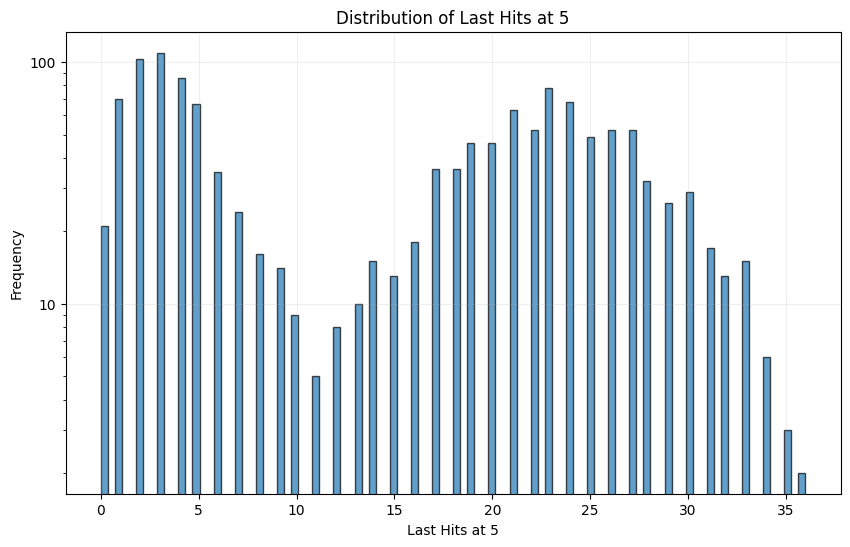

In [7]:
# ... existing code ...
import matplotlib.pyplot as plt
import numpy as np

# Plot distribution of last_hits_at_5
plt.figure(figsize=(10, 6))

# Convert Polars Series to numpy array for matplotlib
last_hits_data = y_test['last_hits_at_5'].to_numpy()

# Create histogram with log scale
plt.hist(last_hits_data, bins=100, log=True, alpha=0.7, edgecolor='black')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xlabel('Last Hits at 5')
plt.ylabel('Frequency')
plt.title('Distribution of Last Hits at 5')
plt.grid(True, alpha=0.2)

plt.show()

## Predictive model

In [8]:
from catboost import CatBoostRegressor, Pool

# Convert to numpy arrays for CatBoost
X_train_np = X_train.to_pandas()
X_test_np = X_test.to_pandas()
y_train_np = y_train['last_hits_at_5'].to_pandas()
y_test_np = y_test['last_hits_at_5'].to_pandas()

model = CatBoostRegressor(iterations=2000, loss_function='Quantile:alpha=0.3', verbose=100, cat_features=input_features)

train_pool = Pool(data=X_train_np, label=y_train_np, cat_features=input_features)
test_pool = Pool(data=X_test_np, label=y_test_np, cat_features=input_features)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)


# bestTest to beat is = 0.4012384946 (MAPE)
# bestTest = 1.315951474 (quantile 0.3)

0:	learn: 3.7134806	test: 3.6632823	best: 3.6632823 (0)	total: 52.9ms	remaining: 1m 45s
100:	learn: 1.3470333	test: 1.3249020	best: 1.3249020 (100)	total: 399ms	remaining: 7.5s
200:	learn: 1.3086832	test: 1.3180345	best: 1.3159515 (131)	total: 814ms	remaining: 7.28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.315951474
bestIteration = 131

Shrink model to first 132 iterations.


## Evaluation

In [10]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error

y_pred = model.predict(X_test_np)

# MSE
mse = mean_squared_error(y_test_np, y_pred)
print("MSE:", mse)

# RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_test_np, y_pred))
print("RMSLE:", rmsle)

# MAE
mae = mean_absolute_error(y_test_np, y_pred)
print("MAE:", mae)

# MAPE
mape = mean_absolute_percentage_error(y_test_np, y_pred)
print("MAPE:", mape)

MSE: 21.414940086015083
RMSLE: 0.43119338317136574
MAE: 3.4393002459821687
MAPE: 151352181278061.72


In [11]:
# Safe MAPE calculation that handles zeros
def safe_mape(y_true, y_pred, epsilon=0.1):
    """
    Calculate MAPE with epsilon to handle zeros
    epsilon=0.1 means we treat 0 last hits as 0.1 for percentage calculation
    """
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Alternative: exclude zeros from MAPE calculation
def mape_excluding_zeros(y_true, y_pred):
    """Calculate MAPE excluding zero values"""
    mask = y_true != 0
    if np.sum(mask) == 0:
        return float('inf')
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calculate both versions
safe_mape_score = safe_mape(y_test_np, y_pred, epsilon=0.1)
mape_no_zeros = mape_excluding_zeros(y_test_np, y_pred)

print(f"Safe MAPE (epsilon=0.1): {safe_mape_score:.2f}%")
print(f"MAPE excluding zeros: {mape_no_zeros:.2f}%")

# 65.93%, 33.91%

Safe MAPE (epsilon=0.1): 65.93%
MAPE excluding zeros: 33.91%


In [12]:
def weighted_evaluation(y_true, y_pred):
    # Higher weights for lower values (supports)
    weights = 1.0 / (y_true + 1)  # Add 1 to avoid division by zero
    
    weighted_mae = np.average(np.abs(y_true - y_pred), weights=weights)
    weighted_mse = np.average((y_true - y_pred)**2, weights=weights)
    
    return weighted_mae, np.sqrt(weighted_mse)

w_mae, w_rmse = weighted_evaluation(y_test_np, y_pred)
print(f"Weighted MAE: {w_mae:.2f}")
print(f"Weighted RMSE: {w_rmse:.2f}")

Weighted MAE: 2.08
Weighted RMSE: 3.13


### Manual evaluation

In [13]:
# Manual test
import pandas as pd

test_hero_id = 5
test_player_account_id = 10366616
# rating = 1603.22

result = model.predict(pd.DataFrame([[test_hero_id, test_player_account_id]], columns=features))

print(result)

[2.16822493]


In [14]:
type(y_test)

polars.dataframe.frame.DataFrame

In [15]:
predicted_df = y_test.clone()
predicted_df = predicted_df.with_columns(pl.Series("predicted", y_pred))

predicted_df

last_hits_at_5,predicted
i64,f64
2,2.053874
21,21.057855
4,2.142168
26,19.335754
17,20.146064
…,…
21,20.564492
33,22.138539
30,19.273768


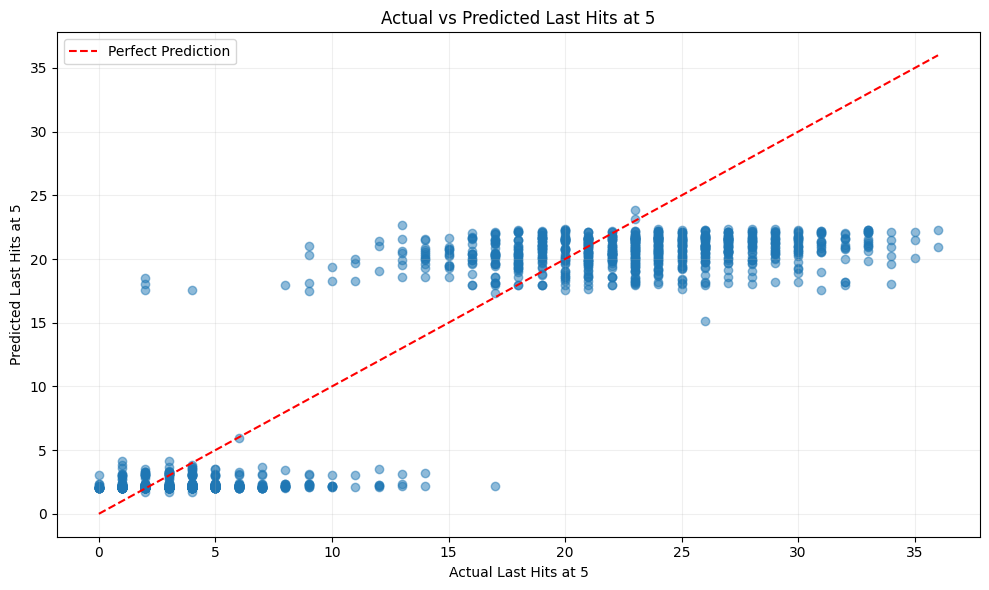

In [16]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(predicted_df['last_hits_at_5'], predicted_df['predicted'], alpha=0.5)

# Add diagonal line representing perfect predictions
max_val = max(predicted_df['last_hits_at_5'].max(), predicted_df['predicted'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
# Labels and title
plt.xlabel('Actual Last Hits at 5')
plt.ylabel('Predicted Last Hits at 5')
plt.title('Actual vs Predicted Last Hits at 5')
plt.legend()

# Add grid for better readability
plt.grid(True, which="both", ls="-", alpha=0.2)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

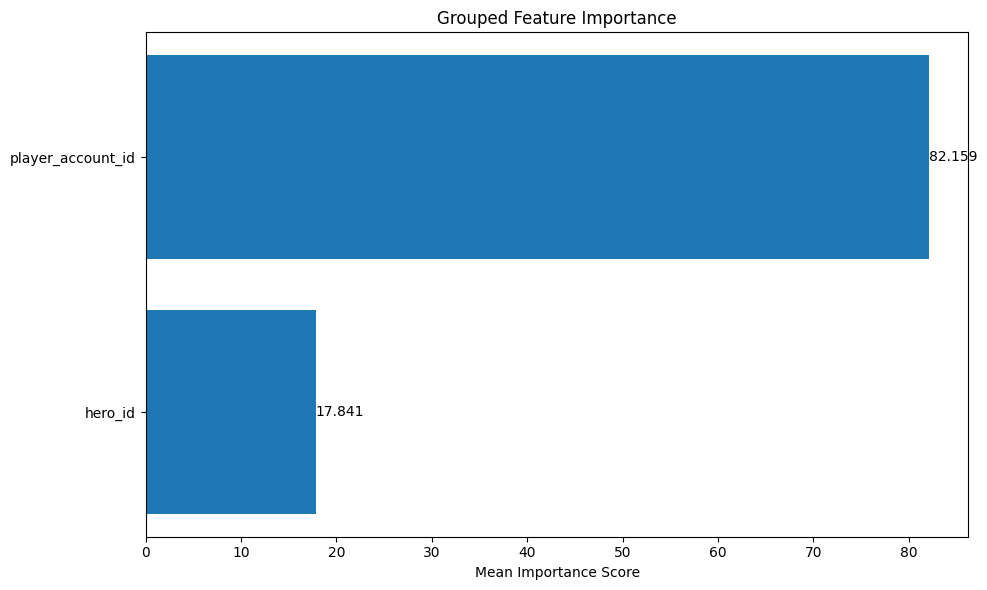

In [17]:
def plot_grouped_feature_importance(model):
    # Get feature importance scores
    feature_importance = model.get_feature_importance()

    # Create the plot
    fig, ax = plt.figure(figsize=(10, 6)), plt.axes()
    
    # Plot horizontal bar chart
    y_pos = np.arange(len(feature_importance))
    ax.barh(y_pos, list(feature_importance))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    
    plt.title('Grouped Feature Importance')
    plt.xlabel('Mean Importance Score')
    
    # Add value labels on the bars
    for i, v in enumerate(feature_importance):
        ax.text(v, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    return plt

# Usage:
plot_grouped_feature_importance(model)
plt.show()